# Affinity Water Test


In [10]:
# Import necessary packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Access the data from the affinity water test link that has been downloaded into a .csv file using pandas df.


In [9]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('Affinity_Water_Night_flow_Monitoring.csv')

# Generate summary statistics
summary_stats = df.describe()
print(summary_stats)

          CENTROID_X     CENTROID_Y  ACTUAL_MIN_NIGHT_FLOW  MIN_NIGHT_FLOW  \
count  974934.000000  974934.000000          974860.000000   974934.000000   
mean       -0.184905      51.647583               3.401128        3.687776   
std         0.481438       0.217169               2.917558        3.106399   
min        -0.769312      50.931029             -28.090000        0.000000   
25%        -0.456611      51.538072               1.533330        1.702778   
50%        -0.360623      51.653081               2.720000        2.955556   
75%        -0.172561      51.804979               4.411110        4.744444   
max         1.387540      52.071938              86.433330      134.638889   

            ObjectId  
count  974934.000000  
mean   487467.500000  
std    281439.348009  
min         1.000000  
25%    243734.250000  
50%    487467.500000  
75%    731200.750000  
max    974934.000000  


### Initial insights from raw data
There are only 2 columns within this dataset that jump out to me here in terms of raw data interpretation from the summary statsitics alone: ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW. 

- In the ACTUAL_MIN_NIGHT_FLOW column, we see that the minimum values are in the negatives, which really doesn't make sense as water flow should be detailed in positive values only (i.e. we can't have negative water flow).
- There’s a significant discrepancy between the min and max values in both ACTUAL_MIN_NIGHT_FLOW and MIN_NIGHT_FLOW columns, indicating potential outliers or data entry errors. The comparison between the actual flow and the expected (minimum) flow could provide useful insights into inefficiencies, leaks, or anomalies within the water distribution network.

The statistics given for the rest make sense, as there are no large outliers and the min and max values make sense in the context of their descriptions.

### Diving into the data

In [13]:
# save the interesting columns into dfs to plot and analyze
actual_min_flow = df['ACTUAL_MIN_NIGHT_FLOW']
min_night_flow = df['MIN_NIGHT_FLOW']

In [38]:
# Count the number of times that the values for both are in the negative
# Set the threshold to be 0 so we can find the number of times the values are in the negative
threshold = 0

# Count the number of times ACTUAL_MIN_NIGHT_FLOW goes below the threshold
negative_count_actual_flow = (df['ACTUAL_MIN_NIGHT_FLOW'] < threshold).sum()
print(f"The number of times ACTUAL_MIN_NIGHT_FLOW is below {threshold}: {negative_count_actual_flow}")

The number of times ACTUAL_MIN_NIGHT_FLOW is below 0: 605


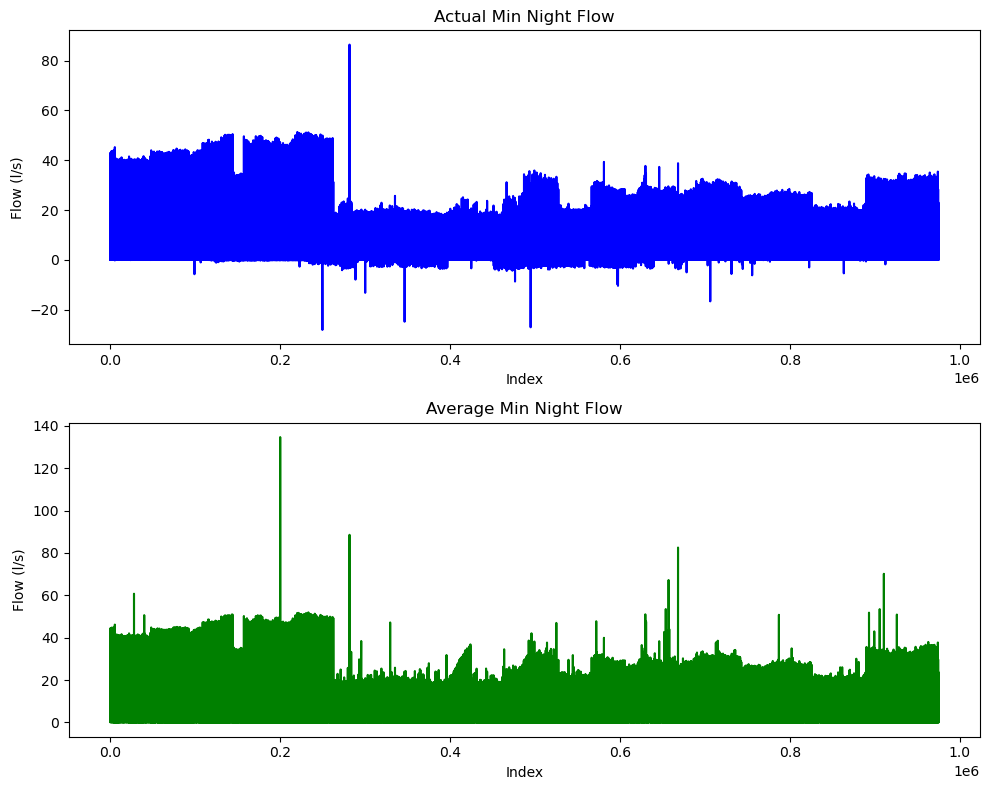

In [36]:
# plot the actual water flow and the average water flow
fig, ax = plt.subplots(2, 1, figsize=(10, 8))  # 2 rows, 1 column

# Plot on the first subplot (Actual Min Night Flow)
ax[0].plot(actual_min_flow, color='blue')
ax[0].set_title('Actual Min Night Flow')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Flow (l/s)')

# Plot on the second subplot (Min Night Flow)
ax[1].plot(min_night_flow, color='green')
ax[1].set_title('Average Min Night Flow')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Flow (l/s)')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Text(0, 0.5, 'Actual Water Flow (L/s)')

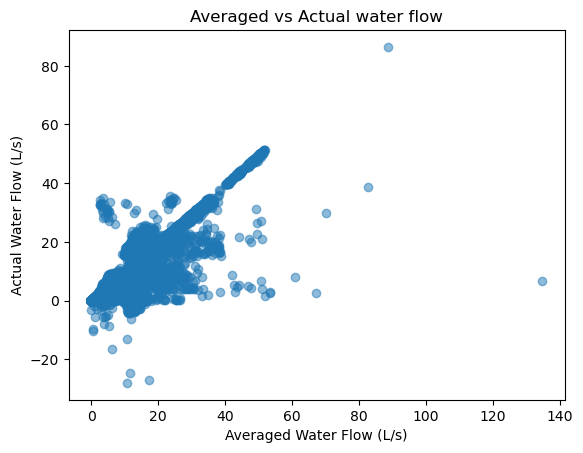

In [18]:
#visualizing the relationship between the two columns and their data
plt.scatter(df['MIN_NIGHT_FLOW'], df['ACTUAL_MIN_NIGHT_FLOW'], alpha=0.5)
plt.title("Averaged vs Actual water flow")
plt.xlabel("Averaged Water Flow (L/s)")
plt.ylabel("Actual Water Flow (L/s)")

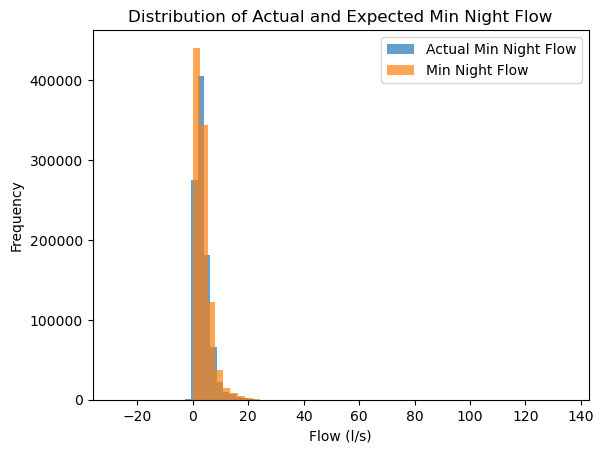

In [30]:
# plotting histogram of the data to show distribution of values
plt.hist(df['ACTUAL_MIN_NIGHT_FLOW'], bins=50, alpha=0.7, label='Actual Min Night Flow')
plt.hist(df['MIN_NIGHT_FLOW'], bins=50, alpha=0.7, label='Min Night Flow')
plt.xlabel('Flow (l/s)')
plt.ylabel('Frequency')
# plt.ylim(0,10000)
# plt.xlim(-40,0)
plt.title('Distribution of Actual and Expected Min Night Flow')
plt.legend()
plt.show()

### Insights Gained